# James Griffin 
## Stat 536 
Resolving Complaints
Much of a persons opinion about a company if formed by how the company responds to complaints about a product. The speed at which the complaints can be resolved depends, in part, on getting the complaint to the right person who can resolve the issue. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to financial companies for response. The dataset CompanyComplaints.csv is a subset of that database (there are about 1.5 million complaints in the original database which you can download if you are interested) and contains complaints sent to companies via email along with which department the complaint was ultimately sent to to be resolved. Ordinarily, companies will hire specialists to sort through the complaints and get them to the right person but in this analysis you will be using machine learning to try to deduce which department the complaint should go to just based on the text of the complaint.

Notice that the dataset does not contain any “explanatory variables” as we are used to. Rather, you will need to build your own set of explanatory variables based on key words or characteristics of the complaint text. Be creative. There is no lower (or upper) limit on the amount of explanatory variables you are allowed to create. Further, you will NOT be graded based on the accuracy of your predictions. Rather, in the “describe methods/models” section of your report you will need to describe and justify what explanatory variables you created. If I feel you did not put much effort into building explanatory variables you will be docked points accordingly.

In your analysis, make sure you answer the following questions:

1. How accurately are you able to classify complaints?
2. What key words or symbols or explanatory variables were useful in classifying complaints?
3. The file WhichDepartment.csv contains information on a few complaints that recently came in. What department(s) does your model think they should be directed to?



In [55]:
import pandas as pd
import numpy as np 
import nltk 
from nltk.corpus import stopwords

import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

import seaborn as sns
color = sns.color_palette()
from wordcloud import WordCloud

import warnings; warnings.simplefilter('ignore')

import logging
from numpy import random
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

#Loading additional helper functions not shown here but provided in the folder
%run nlp_tools.ipynb

In [2]:
data = pd.read_csv('../data/CompanyComplaints.csv')
print(data.shape)
data.head()

(124896, 2)


,Department,Complaint
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
4,Debt collection,While checking my credit report I noticed thre...


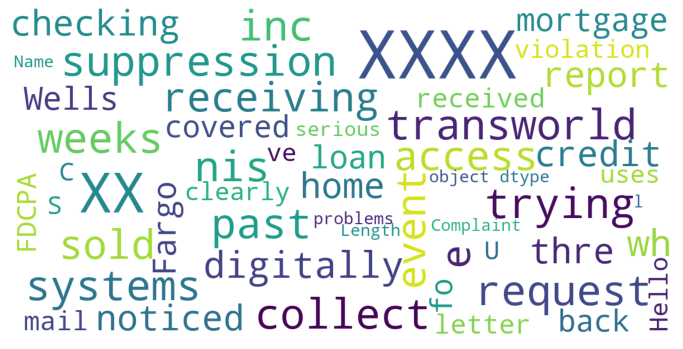

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['Complaint'])
#show_wordcloud(Samsung_Reviews_positive['Reviews'])


In [4]:
cr = data.loc[data.Department == 'Credit reporting, credit repair services, or other personal consumer reports']
dc = data.loc[data.Department == 'Debt collection']
cc = data.loc[data.Department == 'Credit card or prepaid card']
m  = data.loc[data.Department == 'Mortgage']
cs = data.loc[data.Department == 'Checking or Savings Account']
sl = data.loc[data.Department == 'Student loan']
vl = data.loc[data.Department == 'Behicle loan or lease']
mt = data.loc[data.Department == 'Money transfer, virtual currency, or money service']
pd = data.loc[data.Department == 'Payday loan, title loan, or personal loan']

In [5]:
data.Department.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    58526
Debt collection                                                                 23979
Credit card or prepaid card                                                     12531
Mortgage                                                                        10032
Checking or savings account                                                      7353
Student loan                                                                     4280
Vehicle loan or lease                                                            2930
Money transfer, virtual currency, or money service                               2836
Payday loan, title loan, or personal loan                                        2429
Name: Department, dtype: int64

credit reporting most common words


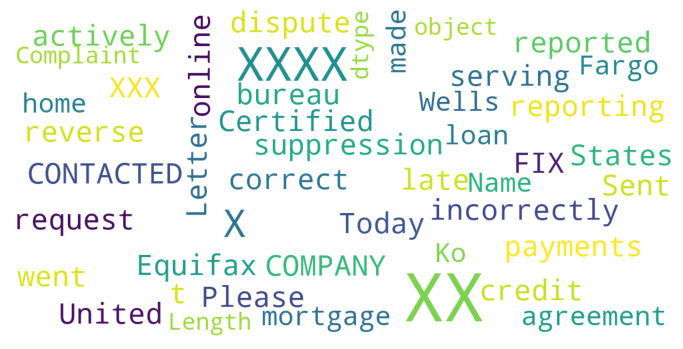

In [6]:
print('credit reporting most common words')
show_wordcloud(cr['Complaint'])

debt collection most common words


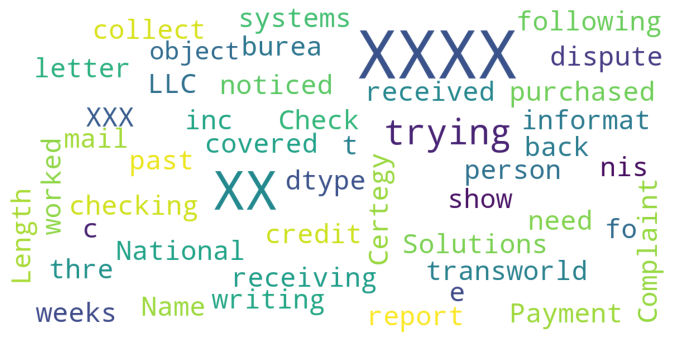

In [7]:
print('debt collection most common words')
show_wordcloud(dc['Complaint'])

credit card most common words


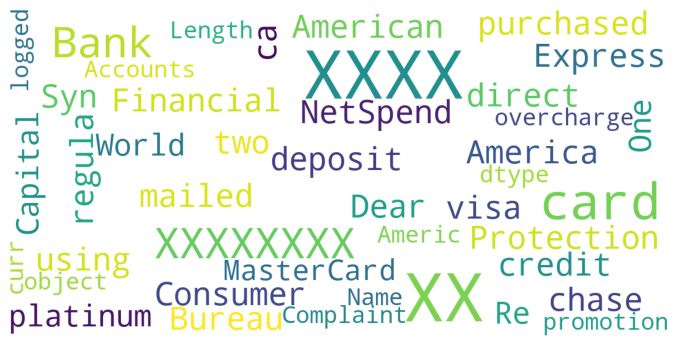

In [8]:
print('credit card most common words')
show_wordcloud(cc['Complaint'])

ok so just using these simple wordclouds, we can see that the different categories do indeed have different most common words, which is good because these will be what we base our model off of to try and build a predictive model 


Now that we have done a little bit of exploritory data analysis, we will proceed with tokenizing  the data 

because language doesn't really have any inherrant meaning as to data, and how a machine understands data, we need to make sense of te data through tokenizaiton, or splitting stirngs into smaller parts called tokens. A token is simply a s equence of characters in text that serve as a unit/ Based on how you create tokens, they can consist of words, emojis, links, or individual characters, often this is done, simply by splittng on white space or punctiation marks. 


In [10]:
#Label encoding 

possible_labels = data.Department.unique()


label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Student loan': 4,
 'Checking or savings account': 5,
 'Credit card or prepaid card': 6,
 'Payday loan, title loan, or personal loan': 7,
 'Vehicle loan or lease': 8}

In [11]:
data['Department'] = data.Department.replace(label_dict)


In [64]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
x_set = ['XX', "XXXX", "XXXXXXXX", "X", "XXX", 'xx'
        'x', 'xxx', 'xxxx', 'xxxxxxxx', '#xxxx',
        '#']
STOPWORDS.update(x_set)

In [30]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
data['clean_text'] = data['Complaint'].apply(clean_text)

In [31]:

data['clean_text'].apply(lambda x: len(x.split(' '))).sum()

12739860

In [28]:
data.head()

,Department,Complaint,clean_text
0,0,transworld systems inc. \nis trying to collect...,transworld systems inc trying collect debt min...
1,1,I would like to request the suppression of the...,would like request suppression following items...
2,0,"Over the past 2 weeks, I have been receiving e...",past 2 weeks receiving excessive amounts telep...
3,2,"I was sold access to an event digitally, of wh...",sold access event digitally screenshots detail...
4,0,While checking my credit report I noticed thre...,checking credit report noticed three collectio...


In [32]:
X = data.clean_text
y = data.Department
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state = 42,
                                                    stratify=data.Department)


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [33]:
X_train

106048    wife xxxx xxxx passed away last year closed ac...
17699     calls every single day multiple phone numbers ...
60029     closed target xxxx master credit card request ...
7346      disputed information credit bureaus company ca...
124438    called capital one xx xx 19 get assistance ref...
                                ...                        
94311     14 years ago victim identity theft someone usi...
76165     credit inquires bank america xxxx credit repor...
77215                                 identity theft victim
45210     received letter credit collection services xxx...
12332     company violated fcra 615 f 15 usc 1681m f f p...
Name: clean_text, Length: 87427, dtype: object

In [34]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [35]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

In [36]:
my_tags = 'cr dc cc m cs sl vl mt pd'.split(' ')

In [37]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

accuracy 0.6561957885185087
              precision    recall  f1-score   support

          cr       0.82      0.51      0.63      7194
          dc       0.61      0.98      0.75     17558
          cc       1.00      0.01      0.02       851
           m       0.94      0.53      0.68      3009
          cs       0.97      0.06      0.12      1284
          sl       0.92      0.23      0.37      2206
          vl       0.65      0.38      0.48      3759
          mt       0.00      0.00      0.00       729
          pd       0.00      0.00      0.00       879

    accuracy                           0.66     37469
   macro avg       0.66      0.30      0.34     37469
weighted avg       0.69      0.66      0.60     37469



In [38]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [39]:
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.793135658811284
              precision    recall  f1-score   support

          cr       0.78      0.70      0.74      7194
          dc       0.80      0.93      0.86     17558
          cc       0.87      0.44      0.58       851
           m       0.82      0.89      0.85      3009
          cs       0.85      0.64      0.73      1284
          sl       0.76      0.70      0.73      2206
          vl       0.77      0.71      0.74      3759
          mt       0.77      0.03      0.05       729
          pd       0.88      0.17      0.29       879

    accuracy                           0.79     37469
   macro avg       0.81      0.58      0.62     37469
weighted avg       0.79      0.79      0.78     37469



In [46]:
from sklearn.ensemble import RandomForestClassifier

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(max_depth=50, 
                                               max_features='sqrt',
                                               min_samples_leaf=2,
                                               min_samples_split=5,
                                               n_estimators=1000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=50, max_features='sqrt',
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=1000))])

In [47]:
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7404254183458325
              precision    recall  f1-score   support

          cr       0.85      0.58      0.69      7194
          dc       0.69      0.98      0.81     17558
          cc       0.95      0.07      0.14       851
           m       0.86      0.76      0.81      3009
          cs       0.95      0.45      0.62      1284
          sl       0.80      0.58      0.67      2206
          vl       0.79      0.55      0.65      3759
          mt       1.00      0.01      0.01       729
          pd       0.95      0.02      0.04       879

    accuracy                           0.74     37469
   macro avg       0.87      0.45      0.49     37469
weighted avg       0.78      0.74      0.71     37469



In [48]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8450719261255971
              precision    recall  f1-score   support

          cr       0.79      0.80      0.80      7194
          dc       0.89      0.91      0.90     17558
          cc       0.78      0.72      0.75       851
           m       0.90      0.89      0.90      3009
          cs       0.85      0.79      0.82      1284
          sl       0.80      0.81      0.80      2206
          vl       0.80      0.78      0.79      3759
          mt       0.64      0.51      0.57       729
          pd       0.70      0.59      0.64       879

    accuracy                           0.85     37469
   macro avg       0.79      0.76      0.77     37469
weighted avg       0.84      0.85      0.84     37469



In [56]:
testd = pd.read_csv("../data/WhichDepartment.csv")
testd.head

<bound method NDFrame.head of                                            Complaint
0  XXXX XXXX/ XXXX XXXX #XXXX is reporting a coll...
1  XXXX are reporting unverified information on m...
2  PREVIOUS OWNER XXXX XXXX THIS IS A FOLLOW UP F...
3  I am writing because as a client of Bank of Am...
4  Re : Hard Inquiry/Unverified on my behave. I r...
5  Equifax keeps reporting accounts that are in s...
6  Wells Fargo refuses to respond to my previous ...
7  This complaint is about Chase Bank. I recieved...
8  Kinum, Inc. ignored my letter ( sent to them w...
9  XXXX XXXX Navient Office of the Customer Advoc...>

In [65]:
testd['clean_test'] = testd['Complaint'].apply(clean_text)

In [66]:
testd

,Complaint,clean_test
0,XXXX XXXX/ XXXX XXXX #XXXX is reporting a coll...,reporting collection account error collection ...
1,XXXX are reporting unverified information on m...,reporting unverified information credit report...
2,PREVIOUS OWNER XXXX XXXX THIS IS A FOLLOW UP F...,previous owner follow case filed consumer repo...
3,I am writing because as a client of Bank of Am...,writing client bank america na claim able righ...
4,Re : Hard Inquiry/Unverified on my behave. I r...,hard inquiry unverified behave recently checke...
5,Equifax keeps reporting accounts that are in s...,equifax keeps reporting accounts someone else ...
6,Wells Fargo refuses to respond to my previous ...,wells fargo refuses respond previous complaint...
7,This complaint is about Chase Bank. I recieved...,complaint chase bank recieved draft morning 15...
8,"Kinum, Inc. ignored my letter ( sent to them w...",kinum inc ignored letter sent within 5 days in...
9,XXXX XXXX Navient Office of the Customer Advoc...,navient office customer advocate pa account in...


In [67]:
test_pred = logreg.predict(testd.clean_test)

In [68]:
test_pred

array([1, 0, 3, 3, 1, 1, 3, 5, 0, 4])

In [69]:
label_dict

{'Debt collection': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Money transfer, virtual currency, or money service': 2,
 'Mortgage': 3,
 'Student loan': 4,
 'Checking or savings account': 5,
 'Credit card or prepaid card': 6,
 'Payday loan, title loan, or personal loan': 7,
 'Vehicle loan or lease': 8}

first: credit reporting,
second: debt collection 
third: mortgage 
fourth: mortgage
fifth: credit reporting 
sixth: credit reporting 
seventh: mortgage
eigth: checking or savings 
ninth: debt collection 
tenth: student loan 